In [ ]:
import numpy as np
from sympy import Symbol, symbols, Matrix, sin, cos, sqrt
from sympy import init_printing
import matplotlib.pyplot as plt


In [ ]:
vx, vy, psis, dpsis, dts, xs, ys = symbols('vx vy \psi \dot\psi T x y')


number_of_states = 6
state = Matrix([xs,ys,vx,vy,psis,dpsis])
state

Matrix([
[       x],
[       y],
[      vx],
[      vy],
[    \psi],
[\dot\psi]])

In [ ]:
# constant turn rate and constant velocity non linear plant model
gs = Matrix([[xs+((vx**2 + vy**2)**0.5)*(cos(psis))*dts],
             [ys+((vx**2 + vy**2)**0.5)*(sin(psis))*dts],
             [vx],
             [vy],
             [psis+dpsis*dts],
             [dpsis]])
gs

Matrix([
[T*(vx**2 + vy**2)**0.5*cos(\psi) + x],
[T*(vx**2 + vy**2)**0.5*sin(\psi) + y],
[                                  vx],
[                                  vy],
[                   T*\dot\psi + \psi],
[                            \dot\psi]])

In [ ]:
gs.jacobian(state)

Matrix([
[1, 0, 1.0*T*vx*(vx**2 + vy**2)**(-0.5)*cos(\psi), 1.0*T*vy*(vx**2 + vy**2)**(-0.5)*cos(\psi), -T*(vx**2 + vy**2)**0.5*sin(\psi), 0],
[0, 1, 1.0*T*vx*(vx**2 + vy**2)**(-0.5)*sin(\psi), 1.0*T*vy*(vx**2 + vy**2)**(-0.5)*sin(\psi),  T*(vx**2 + vy**2)**0.5*cos(\psi), 0],
[0, 0,                                          1,                                          0,                                 0, 0],
[0, 0,                                          0,                                          1,                                 0, 0],
[0, 0,                                          0,                                          0,                                 1, T],
[0, 0,                                          0,                                          0,                                 0, 1]])

In [ ]:
# from data analysis
dt = 1.0/10.0  # Sample Rate is 10Hz


In [ ]:
# Inital Uncertainity matrix
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])
print(P)

# Process Noise Covariance Matrix
sPos = 0.5*5*dt**2  # assume 5m/s2 as maximum acceleration, forcing the vehicle
sYaw = 0.1*dt         # assume 0.1rad/s as maximum turn rate for the vehicle
sVel = 5*dt         # assume 5m/s2 as maximum acceleration, forcing the vehicle
sYawRate = 1*dt         # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle

Q = np.diag([sPos**2, sPos**2, sVel**2, sVel**2, sYaw**2, sYawRate**2])

# measurement covariance matrix
R = np.matrix([[0.01, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.01, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.01, 0.0, 0.0],
               [0.0, 0.0, 0.0, 1.0e-6, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.01]])

[[1000.    0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.]
 [   0.    0.    0.    0.    0. 1000.]]


In [ ]:
## measurement vector
hs = Matrix([[xs],
             [ys],
             [(xs**2 + ys**2)**0.5],
             [psis],
             [(xs*vx + ys*vy)/(xs**2 + ys**2)**0.5]])
hs

Matrix([
[                                  x],
[                                  y],
[                 (x**2 + y**2)**0.5],
[                               \psi],
[(x**2 + y**2)**(-0.5)*(vx*x + vy*y)]])

In [ ]:
## Jacobian of hs
hs.jacobian(state)

Matrix([
[                                                                   1,                                                                    0,                       0,                       0, 0, 0],
[                                                                   0,                                                                    1,                       0,                       0, 0, 0],
[                                         1.0*x*(x**2 + y**2)**(-0.5),                                          1.0*y*(x**2 + y**2)**(-0.5),                       0,                       0, 0, 0],
[                                                                   0,                                                                    0,                       0,                       0, 1, 0],
[vx*(x**2 + y**2)**(-0.5) - 1.0*x*(x**2 + y**2)**(-1.5)*(vx*x + vy*y), vy*(x**2 + y**2)**(-0.5) - 1.0*y*(x**2 + y**2)**(-1.5)*(vx*x + vy*y), x*(x**2 + y**2)**(-0.5), y*(x**2 + y**2)**(-0.5), 0, 0]])

In [ ]:
## data parser

class DataPoint:
  
    
  def __init__(self, d):
    self.timestamp = d['timestamp']
    self.name = d['name']
    self.all = d
    self.raw = []
    self.data = []
    
    if self.name == 'state':
      self.data = [d['x'], d['y'], d['vx'], d['vy'], d['yaw'], d['yaw_rate']]
      self.raw = self.data.copy()
    
    elif self.name == 'lidar':
      self.data = [d['x'], d['y'], 0, 0, 0]
      self.raw = [d['x'], d['y']]
                  
    elif self.name == 'radar':
      self.data = [0, 0, d['rho'], d['phi'], d['drho']]
      self.raw = [d['rho'], d['phi'], d['drho']]
    
    self.all['processed_data'] = self.data
    self.all['raw'] = self.raw
    
  def get_dict(self):
    return self.all

  def get_raw(self):
    return self.raw

  def get(self):
    return self.data

  def get_timestamp(self):
    return self.timestamp

  def get_name(self):
    return self.name

def parse_data(file_path):

  all_sensor_data = []
  all_ground_truths = []  

  with open(file_path) as f:
      
    for line in f:
      data = line.split() 
      
      if data[0]  == 'L':
        
        sensor_data = DataPoint({ 
          'timestamp': int(data[3]),
          'name': 'lidar',
          'x': float(data[1]), 
          'y': float(data[2])
        })
        
        g = {'timestamp': int(data[3]),
             'name': 'state',
             'x': float(data[4]),
             'y': float(data[5]),
             'vx': float(data[6]),
             'vy': float(data[7]),
             'yaw' : float(data[8]),
             'yaw_rate' : float(data[9])
        }
          
        ground_truth = DataPoint(g)
                
      elif data[0] == 'R':
          
        sensor_data = DataPoint({ 
          'timestamp': int(data[4]),
          'name': 'radar',
          'rho': float(data[1]), 
          'phi': float(data[2]),
          'drho': float(data[3])
        })
       
        g = {'timestamp': int(data[4]),
             'name': 'state',
             'x': float(data[5]),
             'y': float(data[6]),
             'vx': float(data[7]),
             'vy': float(data[8]),
             'yaw' : float(data[9]),
             'yaw_rate' : float(data[10])
        }
        ground_truth = DataPoint(g)
          
      all_sensor_data.append(sensor_data)
      all_ground_truths.append(ground_truth)

  return all_sensor_data, all_ground_truths

all_sensor_data, all_ground_truths = parse_data("/content/data_ekf.txt")

# New Section

In [ ]:
# initial state i.e. x[0]
x = np.matrix([[1, 1, 1, 1, 1, 1]]).T
I = np.eye(number_of_states)

In [ ]:
all_estimations = []

for filterstep in range(len(all_sensor_data)):

  # Prediction
  x[0] = dt * (np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.cos(x[4]) + x[0] 
  x[1] = dt * (np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.sin(x[4]) + x[1]
  x[2] = x[2]
  x[3] = x[3]
  x[4] = dt * x[5] + x[4] 
  x[5] = x[5]

  # Calculate the Jacobian of the Dynamic Matrix A
  a02 = float((dt * x[2] * np.cos(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a03 = float((dt * x[3] * np.cos(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a12 = float((dt * x[2] * np.sin(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a13 = float((dt * x[3] * np.sin(x[4])) / (np.sqrt(x[2] ** 2 + x[3] ** 2)))
  a04 = float(-dt*(np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.sin(x[4]))
  a14 = float(-dt*(np.sqrt(x[2] ** 2 + x[3] ** 2)) * np.cos(x[4]))

  JA = np.matrix([[1.0, 0.0, a02, a03, a04, 0.0],
                  [0.0, 1.0, a12, a13, a14, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, dt],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
  # Project the error covariance ahead
  P = JA*P*JA.T + Q

  # Measurement Update (Correction) & Kalman Gain
  hx = np.matrix([[float(x[0])],
                  [float(x[1])],
                  [float(np.sqrt(x[0]**2 + x[1]**2))],
                  [float(x[4])],
                  [float((x[2]*x[0] + x[3]*x[1])/(np.sqrt(x[0] ** 2 + x[1] ** 2)))]])
  
  if all_sensor_data[filterstep].get_name() == 'lidar':
    JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
  else:
    h20 = float(x[0]/(np.sqrt(x[0] ** 2 + x[1] ** 2)))
    h21 = float(x[1]/(np.sqrt(x[0] ** 2 + x[1] ** 2)))
    h40 = float((x[2] / (np.sqrt(x[0] ** 2 + x[1] ** 2))) - ((x[0] * (x[0]*[2] + x[1]*x[3])) / (np.power((x[0] ** 2 + x[1] ** 2), 1.5))))
    h41 = float((x[3] / (np.sqrt(x[0] ** 2 + x[1] ** 2))) - ((x[1] * (x[0]*[2] + x[1]*x[3])) / (np.power((x[0] ** 2 + x[1] ** 2), 1.5))))
    h42 = float(x[0]/np.sqrt(x[0] ** 2 + x[1] ** 2))
    h43 = float(x[1]/np.sqrt(x[0] ** 2 + x[1] ** 2))

    JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                    [h20, h21, 0.0, 0.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [h40, h41, h42, h43, 0.0, 0.0]])
    
  S = JH*P*JH.T + R
  K = (P*JH.T) * np.linalg.inv(S)

  # Update the estimate via
  Z = np.array(all_sensor_data[filterstep].get_dict()['processed_data']).reshape(JH.shape[0],1)
  y = Z - (hx)                         
  x = x + (K*y)

  # Update the error covariance
  P = (I - (K*JH))*P

  # save states for analysis
  all_estimations.append(x.reshape(-1).tolist())

In [ ]:
def print_EKF_data(all_sensor_data, all_ground_truths, all_state_estimations):
  print("-----------------------------------------------------------")
  print("NUMBER OF DATA POINTS:", len(all_sensor_data))
  print("-----------------------------------------------------------")  

  i = 1
  for s, p, t in zip(all_sensor_data, all_state_estimations, all_ground_truths):
      
    print("-----------------------------------------------------------")
    print("#", i, ":", s.get_timestamp())
    print("-----------------------------------------------------------")  

    if s.get_name() == 'lidar':
      x, y = s.get_raw()
      print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", x, y))
    else:
      rho, phi, drho = s.get_raw()
      print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("RADAR:", rho, phi, drho))  

    x = all_state_estimations[i-1][0][0]
    y = all_state_estimations[i-1][0][1]
    vx = all_state_estimations[i-1][0][2]
    vy = all_state_estimations[i-1][0][3]
    psi = all_state_estimations[i-1][0][4]
    dpsi = all_state_estimations[i-1][0][5]
    print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("PREDICTION:", x, y, vx, vy, psi, dpsi))  

    x, y, vx, vy, psi, dpsi = t.get()
    print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("TRUTH:", x, y, vx, vy, psi, dpsi))  

    i += 1

In [ ]:
print_EKF_data(all_sensor_data, all_ground_truths, all_estimations)

-----------------------------------------------------------
NUMBER OF DATA POINTS: 500
-----------------------------------------------------------
-----------------------------------------------------------
# 1 : 1477010443000000
-----------------------------------------------------------
LIDAR:          |    0.312 |    0.580 |
PREDICTION:     |    0.312 |    0.580 |    0.950 |    0.950 |    1.111 |    1.000 |
TRUTH:          |    0.600 |    0.600 |    5.200 |    0.000 |    0.000 |    0.007 |
-----------------------------------------------------------
# 2 : 1477010443050000
-----------------------------------------------------------
RADAR:          |    1.015 |    0.554 |    4.893 |
PREDICTION:     |    0.492 |    0.890 |   -2.588 |    7.060 |    0.554 |   -1.013 |
TRUTH:          |    0.860 |    0.600 |    5.200 |    0.002 |    0.000 |    0.014 |
-----------------------------------------------------------
# 3 : 1477010443100000
---------------------------------------------------------

(500, 6)


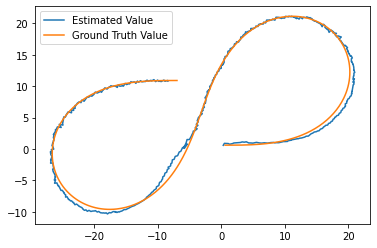

In [ ]:
ground = []
for i in range(len(all_ground_truths)):
  ground.append(all_ground_truths[i].get())
  
ground = np.array(ground)
all_estimations = np.array(all_estimations)
all_estimations = all_estimations.reshape(500,-1)
print(all_estimations.shape)
plt.plot(all_estimations[:, 0], all_estimations[:,1],label = "Estimated Value")
plt.plot(ground[:,0],ground[:,1],label = "Ground Truth Value")

plt.legend()
plt.show()